In [1]:
import torch.nn as nn
import torch.nn.functional as F

import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize the autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels, out_channels)
        
    def forward(self, x):
        x = self.upconv(x)
        x = self.conv(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels):
        super(Encoder, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        self.bridge = ConvBlock(512, 1024)
        
    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)
        b = self.bridge(p4)
        return s1, s2, s3, s4, b

class AutoencoderDecoder(nn.Module):
    def __init__(self, out_channels):
        super(AutoencoderDecoder, self).__init__()
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)
        self.output = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = torch.sigmoid(self.output(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = AutoencoderDecoder(out_channels)
        
    def forward(self, x):
        _, _, _, _, encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
        
    def forward(self, x, skip_connection):
        x = self.upconv(x)
        x = torch.cat((x, skip_connection), dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = Encoder(in_channels)
        self.dec1 = UNetDecoderBlock(1024, 512)
        self.dec2 = UNetDecoderBlock(512, 256)
        self.dec3 = UNetDecoderBlock(256, 128)
        self.dec4 = UNetDecoderBlock(128, 64)
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        s1, s2, s3, s4, b = self.encoder(x)
        x = self.dec1(b, s4)
        x = self.dec2(x, s3)
        x = self.dec3(x, s2)
        x = self.dec4(x, s1)
        x = torch.sigmoid(self.output(x))
        return x

# Initialize U-Net model
random_wt_unet_model = UNet(in_channels=3, out_channels=3).to(device)


/home/sprasad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize U-Net model
random_wt_unet_model = UNet(in_channels=3, out_channels=3).to(device)
pretrained_wt_unet_model=UNet(in_channels=3, out_channels=3).to(device)
# Accessing weights example (if needed)
for name, param in random_wt_unet_model.named_parameters():
    if 'weight' in name:
        print(name, param.data)


encoder.enc1.conv.conv1.weight tensor([[[[ 0.1343,  0.1332,  0.1051],
          [ 0.1163, -0.0918, -0.0713],
          [-0.0011, -0.1640, -0.0459]],

         [[-0.0304,  0.0733,  0.1809],
          [-0.1826,  0.0245,  0.0020],
          [-0.0678,  0.1087,  0.1152]],

         [[-0.0427,  0.0060, -0.0924],
          [-0.1710,  0.0407, -0.0124],
          [-0.0885, -0.0520,  0.1820]]],


        [[[-0.0042, -0.0227, -0.1707],
          [-0.0988, -0.0134, -0.0899],
          [-0.0634, -0.0022, -0.1704]],

         [[-0.1496,  0.0718,  0.0622],
          [ 0.0021, -0.0103, -0.1094],
          [-0.1347,  0.1539,  0.1298]],

         [[ 0.0679, -0.1682,  0.1391],
          [-0.1192,  0.1567,  0.0678],
          [-0.1295, -0.1068, -0.1450]]],


        [[[-0.0451,  0.1565,  0.0688],
          [ 0.0187,  0.0723,  0.1475],
          [-0.1859,  0.0030,  0.0836]],

         [[-0.0267, -0.0948, -0.1059],
          [ 0.1753, -0.0153,  0.1289],
          [-0.1756,  0.1741,  0.1521]],

         [[-0

In [3]:
# Load pretrained weights
pretrained_weights_path = 'unet_model_weights.pth'
pretrained_dict = torch.load(pretrained_weights_path, map_location=device)

In [4]:


# Load the state_dict into the model
pretrained_wt_unet_model.load_state_dict(pretrained_dict)
# Ensure the model is in evaluation mode
pretrained_wt_unet_model.eval()

UNet(
  (encoder): Encoder(
    (enc1): EncoderBlock(
      (conv): ConvBlock(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (enc2): EncoderBlock(
      (conv): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): MaxPool2d(kernel_size=2, stri

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Visualisation

In [25]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import random
import matplotlib.pyplot as plt

# Constants
SIZE = 256
BATCH_SIZE = 16
EPOCHS = 25
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess the images and labels
image_folder_path = '/data1/sprasad/data/train/originalTrain/image'
label_folder_path = '/data1/sprasad/autoencoder3/label'

image_files = [f for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]
label_files = [f for f in os.listdir(label_folder_path) if os.path.isfile(os.path.join(label_folder_path, f))]

# Ensure image files are sorted to match with label files
image_files.sort()
label_files.sort()

# Debug: Print the number of images and labels found
print(f"Found {len(image_files)} images and {len(label_files)} labels")

img_data = []
label_data = []
image_names = []
label_names = []

for img_file, label_file in zip(image_files, label_files):
    img_path = os.path.join(image_folder_path, img_file)
    label_path = os.path.join(label_folder_path, label_file)

    if os.path.exists(label_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(label_path)  

        if img is None:
            print(f"Image {img_path} could not be loaded.")
            continue
        if mask is None:
            print(f"Mask {label_path} could not be loaded.")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)

        img_data.append(img)
        label_data.append(mask)
        image_names.append(img_file)
        label_names.append(label_file)
    else:
        print(f"Label not found for {img_file}")

# Check if the number of images matches the number of labels
if len(img_data) != len(label_data):
    raise ValueError("The number of images does not match the number of labels")

# Convert lists to numpy arrays
img_array = np.array(img_data).astype('float32') / 255.0
label_array = np.array(label_data).astype('float32')/255  # Keep labels as integers

# Debug: Print shapes of the arrays
print(f"Image array shape: {img_array.shape}")
print(f"Label array shape: {label_array.shape}")

# Convert numpy arrays to PyTorch tensors
img_tensor = torch.from_numpy(img_array).permute(0, 3, 1, 2)  # Change to (B, C, H, W) format
label_tensor = torch.from_numpy(label_array).permute(0,3,1,2)

# Debug: Check the shapes of the tensors
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, img_names, lbl_names):
        self.images = images
        self.labels = labels
        self.img_names = img_names
        self.lbl_names = lbl_names

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.img_names[idx], self.lbl_names[idx]

# Create Dataset and DataLoader
dataset = CustomDataset(img_tensor, label_tensor, image_names, label_names)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Convert DataLoader to lists for train set
train_images = []
train_labels = []
train_img_names = []
train_lbl_names = []

for batch in dataloader:
    images, labels, img_names, lbl_names = batch
    train_images.append(images)
    train_labels.append(labels)
    train_img_names.extend(img_names)
    train_lbl_names.extend(lbl_names)

# Convert lists to tensors
train_images = torch.cat(train_images)
train_labels = torch.cat(train_labels)

# Debug: Print shapes of the final training set
print(f"Training image tensor shape: {train_images.shape}")
print(f"Training label tensor shape: {train_labels.shape}")



Found 87 images and 87 labels
Image array shape: (87, 256, 256, 3)
Label array shape: (87, 256, 256, 3)
Image tensor shape: torch.Size([87, 3, 256, 256])
Label tensor shape: torch.Size([87, 3, 256, 256])
Training image tensor shape: torch.Size([87, 3, 256, 256])
Training label tensor shape: torch.Size([87, 3, 256, 256])


In [12]:
np.unique(label_tensor[0])

array([0., 1.])

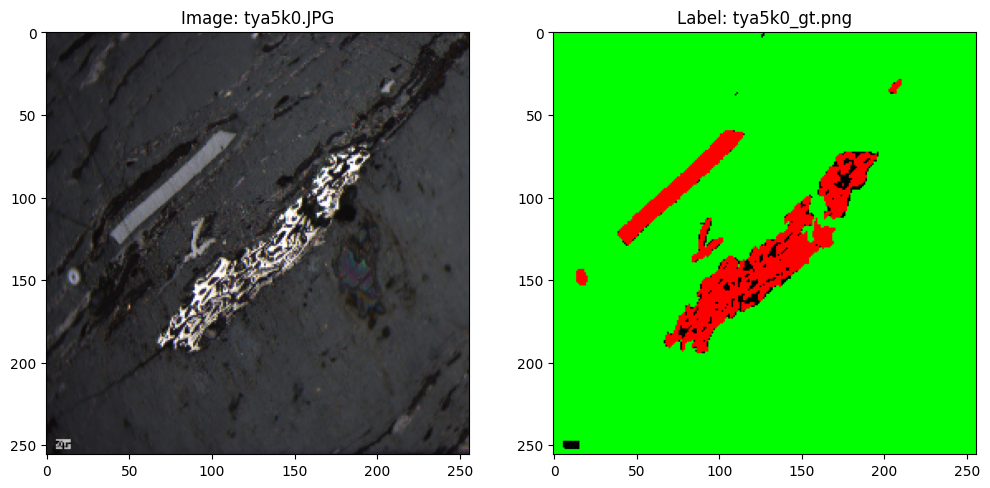

In [31]:
# Visualize a random image and its corresponding label
image_number = random.randint(0, len(train_images) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_images[image_number].permute(1, 2, 0).numpy())
plt.title(f"Image: {train_img_names[image_number]}")
plt.subplot(122)
plt.imshow(train_labels[image_number].permute(1, 2, 0).numpy())
plt.title(f"Label: {train_lbl_names[image_number]}")
plt.show()


In [32]:
# Constants
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 1e-4

In [33]:
mask=cv2.imread('label/3gpbh5_gt.png')
mask.shape

(1024, 1360, 3)

In [34]:
import torch.optim as optim
# Define your loss function
criterion = nn.BCEWithLogitsLoss()  # Example loss function, adjust as per your task
# Define optimizer
optimizer = optim.Adam(pretrained_wt_unet_model.parameters(), lr=LEARNING_RATE)

# Split your data into training and validation sets (assuming you have X_train, y_train, X_test, y_test from previous steps)
X_train, X_val, y_train, y_val = train_test_split(img_tensor, label_tensor, test_size=0.2, random_state=42)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [39]:
def calculate_iou(outputs, labels):
    """
    Compute Intersection over Union (IoU) for batch of predicted and target masks.
    This version handles multi-channel binary labels.
    """
    # Apply sigmoid to outputs to get probabilities
    outputs = torch.sigmoid(outputs)
    
    # Convert probabilities to binary using threshold
    outputs = outputs > 0.5
    labels = labels > 0.5  # Ensure labels are in binary format (0, 1)
    
    ious = []
    for channel in range(outputs.shape[1]):  # Iterate over each channel
        intersection = (outputs[:, channel].bool() & labels[:, channel].bool()).float().sum((1, 2))  # Compute intersection
        union = (outputs[:, channel].bool() | labels[:, channel].bool()).float().sum((1, 2))  # Compute union
        
        iou = (intersection + 1e-6) / (union + 1e-6)  # Add small epsilon to avoid division by zero
        ious.append(iou.mean().item())  # Store mean IoU for the channel
    
    return sum(ious) / len(ious)  # Return the mean IoU across all channels


In [37]:
import torch.nn.functional as F

def focal_tversky_loss(outputs, labels, alpha=0.5, beta=0.5, gamma=4/3):
    """
    Compute the Focal Tversky Loss for a batch of predicted and target masks.
    
    Parameters:
    - outputs (torch.Tensor): The predicted masks with shape [B, C, H, W].
    - labels (torch.Tensor): The ground truth masks with shape [B, C, H, W].
    - alpha (float): Weight of false positives.
    - beta (float): Weight of false negatives.
    - gamma (float): Focusing parameter.
    
    Returns:
    - loss (torch.Tensor): The computed Focal Tversky Loss.
    """
    # Apply sigmoid to outputs to get probabilities
    outputs = torch.sigmoid(outputs)
    
    # Compute the Tversky index
    tp = (outputs * labels).sum(dim=(2, 3))  # True positives
    fp = ((1 - labels) * outputs).sum(dim=(2, 3))  # False positives
    fn = (labels * (1 - outputs)).sum(dim=(2, 3))  # False negatives
    
    tversky_index = (tp + 1e-6) / (tp + alpha * fp + beta * fn + 1e-6)
    
    # Compute the Focal Tversky Loss
    loss = (1 - tversky_index) ** gamma
    return loss.mean()


In [21]:
img=cv2.imread('/data1/sprasad/data/train/originalTrain/image/17gw5j.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (SIZE, SIZE))

img=np.array(img)


        


In [50]:
pretrained_wt_unet_model.train()
for epoch in range(EPOCHS):
    train_loss = 0.0
    train_iou = 0.0
    val_loss = 0.0
    val_iou = 0.0

    # Training
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        # Forward pass
        outputs = pretrained_wt_unet_model(images)
        
        # Calculate loss
        loss = focal_tversky_loss(outputs, masks)
        iou = calculate_iou(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_iou += iou * images.size(0)

    # Validation
    pretrained_wt_unet_model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            # Forward pass
            outputs = pretrained_wt_unet_model(images)

            # Debug: Check the shapes
            #print(f"Outputs shape: {outputs.shape}")
            #print(f"Masks shape: {masks.shape}")
            
            # Calculate loss
            loss = focal_tversky_loss(outputs, masks)
            iou = calculate_iou(outputs, masks)

            val_loss += loss.item() * images.size(0)
            val_iou += iou * images.size(0)

    # Average losses and IoU
    train_loss /= len(train_loader.dataset)
    train_iou /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_iou /= len(val_loader.dataset)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    torch.save(pretrained_wt_unet_model.state_dict(), f'model_weights/pretrained_wt_unet_model_epoch_{epoch+1}.pth')

Epoch [1/25], Train Loss: 0.9305, Train IoU: 0.0453, Val Loss: 0.9632, Val IoU: 0.0162
Epoch [2/25], Train Loss: 0.9273, Train IoU: 0.0453, Val Loss: 0.9630, Val IoU: 0.0162
Epoch [3/25], Train Loss: 0.9273, Train IoU: 0.0464, Val Loss: 0.9630, Val IoU: 0.0165
Epoch [4/25], Train Loss: 0.9271, Train IoU: 0.0459, Val Loss: 0.9629, Val IoU: 0.0219
Epoch [5/25], Train Loss: 0.9268, Train IoU: 0.0534, Val Loss: 0.9629, Val IoU: 0.0244
Epoch [6/25], Train Loss: 0.9266, Train IoU: 0.0537, Val Loss: 0.9629, Val IoU: 0.0251
Epoch [7/25], Train Loss: 0.9266, Train IoU: 0.0548, Val Loss: 0.9628, Val IoU: 0.0263
Epoch [8/25], Train Loss: 0.9264, Train IoU: 0.0551, Val Loss: 0.9626, Val IoU: 0.0312
Epoch [9/25], Train Loss: 0.9266, Train IoU: 0.0567, Val Loss: 0.9628, Val IoU: 0.0341
Epoch [10/25], Train Loss: 0.9265, Train IoU: 0.0608, Val Loss: 0.9630, Val IoU: 0.0221
Epoch [11/25], Train Loss: 0.9267, Train IoU: 0.0531, Val Loss: 0.9628, Val IoU: 0.0282
Epoch [12/25], Train Loss: 0.9266, Train 

In [51]:
pretrained_wt_unet_model.load_state_dict(torch.load('model_weights/pretrained_wt_unet_model_epoch_25.pth'))


<All keys matched successfully>

In [52]:
# Ensure the model is in evaluation mode
pretrained_wt_unet_model.eval()
# Initialize metrics
val_loss = 0.0
val_iou = 0.0

# Iterate over the validation dataset
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = pretrained_wt_unet_model(images)

        # Calculate loss
        loss = focal_tversky_loss(outputs, masks.float())
        iou = calculate_iou(outputs, masks)

        # Accumulate loss and IoU
        val_loss += loss.item() * images.size(0)
        val_iou += iou * images.size(0)

# Calculate average loss and IoU
val_loss /= len(val_loader.dataset)
val_iou /= len(val_loader.dataset)

# Print validation metrics
print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}")


Validation Loss: 0.9627, Validation IoU: 0.0302


In [79]:
outputs[0].shape

(3, 256, 256)

In [62]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader, Dataset

# Load the model weights
pretrained_wt_unet_model.load_state_dict(torch.load('model_weights/pretrained_wt_unet_model_epoch_25.pth'))
pretrained_wt_unet_model.eval()  # Set the model to evaluation mode

# Test image directory
test_image_folder_path = '/data1/sprasad/data/test'

# Load and preprocess the test images
test_image_files = [f for f in os.listdir(test_image_folder_path) if os.path.isfile(os.path.join(test_image_folder_path, f))]
test_image_files.sort()

# Custom Dataset for Test Images
class TestDataset(Dataset):
    def __init__(self, image_folder, image_files, size=256):
        self.image_folder = image_folder
        self.image_files = image_files
        self.size = size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size))
        img = img.astype('float32') / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)  # Convert to (C, H, W)
        return img, img_file

# Create Test DataLoader
test_dataset = TestDataset(test_image_folder_path, test_image_files, size=256)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # Function to save predictions in the required format
# def save_prediction(prediction, img_file, output_folder='predictions'):
#     image_id = os.path.splitext(img_file)[0]
#     output_file = f"{image_id}_pred.npy"
#     np.save(os.path.join(output_folder, output_file), prediction)

# # Create the output directory if it doesn't exist
output_folder = 'predictions'
# os.makedirs(output_folder, exist_ok=True)

# # Generate and save predictions
# with torch.no_grad():
#     for images, img_files in test_loader:
#         images = images.to(DEVICE)
#         outputs = pretrained_wt_unet_model(images)
#         outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
#         outputs = (outputs >= 0.5).float()
#         outputs = outputs.cpu().numpy()

#         for i in range(outputs.shape[0]):
#             prediction = outputs[i]
#             img_file = img_files[i]
# #             save_prediction(prediction, img_file, output_folder)

# print("Predictions saved successfully.")


In [75]:
import cv2

# Function to save prediction with maximum probability
def save_predictions_max_prob(prediction, img_file, output_folder):
    # Resize prediction to original image size
    resized_prediction = cv2.resize(prediction.transpose(1, 2, 0), (1360, 1024), interpolation=cv2.INTER_NEAREST)
    
    # Determine class with maximum probability for each pixel
    max_class_prediction = np.argmax(resized_prediction, axis=2)+1  # +1 to convert index to class ID
    
    # Save the maximum probability prediction
    filename = os.path.splitext(img_file)[0] + '_max_prob_pred.npy'
    np.save(os.path.join(output_folder, filename), max_class_prediction)

# Generate and save predictions
with torch.no_grad():
    for images, img_files in test_loader:
        images = images.to(DEVICE)
        outputs = pretrained_wt_unet_model(images)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        outputs = outputs.cpu().numpy()
        for i in range(outputs.shape[0]):
            prediction = outputs[i]
            img_file = img_files[i]
            save_predictions_max_prob(prediction, img_file, output_folder)

print("Predictions saved successfully.")


Predictions saved successfully.


In [76]:
import numpy as np
prd=np.load('predictions/gp0mak_max_prob_pred.npy')
prd

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [77]:
np.unique(prd)

array([1, 2, 3])

In [80]:
prd.shape

(1024, 1360)